# Data Exploration 
## conclusion: 
#### smaller size of lesion removed, higher patient's survival rate.
#### different folder may from the same patient but different stages of cancer
#### different labs may use various staining techniques, making the same cells look different in various images

In [1]:
# check how many medical cases we have
import os
PATH = './patients/'
medCases = os.listdir(PATH)
medCases.remove('.DS_Store')
print('Number of medical cases: ', len(medCases))

Number of medical cases:  279


In [2]:
pos_num, neg_num = 0, 0
for case in medCases:
    # calc number of negative cases
    cls0_path = PATH + case + '/0'
    cls0_pats = os.listdir(cls0_path)
    neg_num += len(cls0_pats)

    # calc number of positive cases
    cls1_path = PATH + case + '/1'
    cls1_pats = os.listdir(cls1_path)
    pos_num += len(cls1_pats)

all_pats = pos_num + neg_num  
print('Number of positive cases: ', pos_num)
print('Number of negative cases: ', neg_num)
print(f'Ratio of positive cases: {pos_num / (pos_num + neg_num):.2f}')
print(f'Ratio of negative cases: {neg_num / (pos_num + neg_num):.2f}')
print('total number of cases: ', all_pats)


Number of positive cases:  78786
Number of negative cases:  198738
Ratio of positive cases: 0.28
Ratio of negative cases: 0.72
total number of cases:  277524


Clearly, we can see from the above results, our dataset is imbalanced, that indicates that their diseases are really severe so the whole organs were removed.

Also, we have only 279 medical cases, so it is easy for our models to be overfitted so we can do cross validation if we got fancy GPUs, but for learning purposes, we decide to split the dataset into training, validation, and testing


## Explore data structure


In [3]:
import pandas as pd
import numpy as np
observations = pd.DataFrame(index=np.arange(1, all_pats + 1), columns=['medical_case', 'class', 'path'])

row = 1
# fill in the dataframe
for i, case in enumerate(medCases):
    cls0_path = PATH + case + '/0'
    cls0_pats = os.listdir(cls0_path)
    cls1_path = PATH + case + '/1'
    cls1_pats = os.listdir(cls1_path)

    for j, pat in enumerate(cls0_pats):
        observations.loc[row, 'medical_case'] = case
        observations.loc[row, 'class'] = 0
        observations.loc[row, 'path'] = cls0_path + '/' + pat
        row += 1

    for k, pat in enumerate(cls1_pats):
        observations.loc[row, 'medical_case'] = case
        observations.loc[row, 'class'] = 1
        observations.loc[row, 'path'] = cls1_path + '/' + pat
        row += 1

# save the dataframe (all data)
# observations.to_csv('observations.csv', index=True)

# downsampling to 10000
rand_cases = np.random.choice(observations.index.values, 10000, replace=False)
observations = observations.loc[rand_cases]


all_pats = 10000
observations[:10000].to_csv('observations_10000.csv', index=True)




randomly selected patient:  161681
class:  1
path:  ./patients/12752/1/12752_idx5_x1051_y351_class1.png


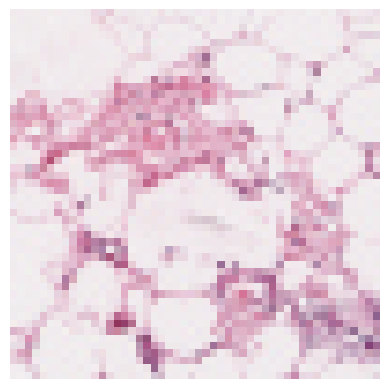

number of missing values: 
medical_case    0
class           0
path            0
dtype: int64


In [4]:
# check sanity of the dataframe
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
%matplotlib inline

# randomly select a patient
rand_pat = np.random.choice(observations.index.values, 1)[0] 
print('randomly selected patient: ', rand_pat)
print('class: ', observations.loc[rand_pat, 'class'])
print('path: ', observations.loc[rand_pat, 'path'])

# show the image
img = mpimg.imread(observations.loc[rand_pat, 'path'])
plt.axis('off')
plt.grid(False)
plt.imshow(img, cmap='gray')
plt.show()

# check if there is any missing value
print('number of missing values: \n', observations.isnull().sum(), sep='')

randomly selected medical cases:  [131304 169382 167862 111613 188094  31397 262472  18608 201713]
rand_cases'


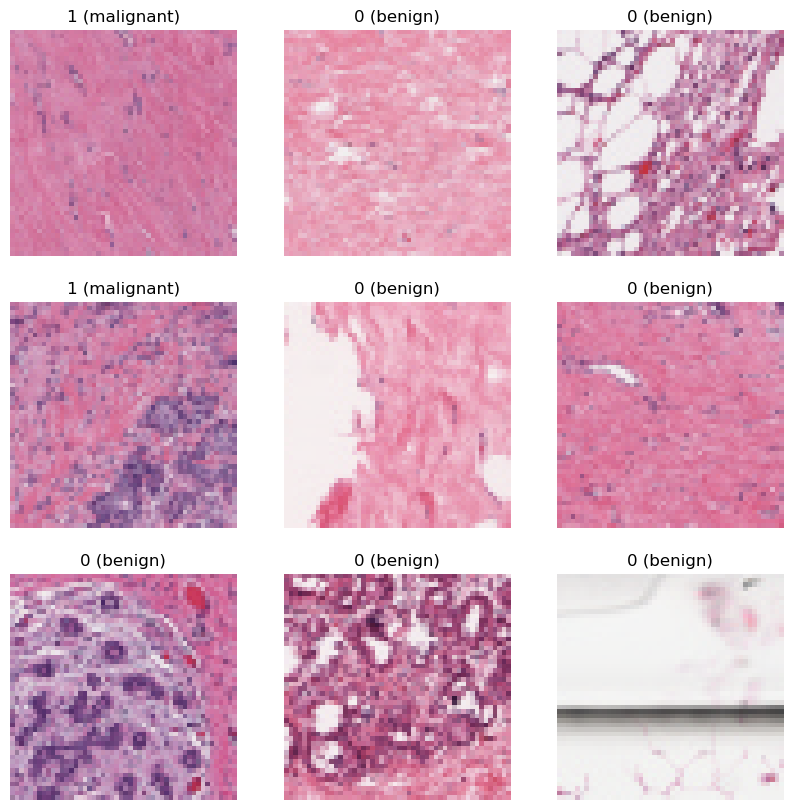

In [5]:
# this time randomly select 9 medical cases (aka patients)
import cv2
rand_cases = np.random.choice(observations.index.values, 9, replace=False)
print('randomly selected medical cases: ', rand_cases)
print("rand_cases'")

# show the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = cv2.imread(observations.loc[rand_cases[i], 'path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

    ax.set_title('0 (benign)') if observations.loc[rand_cases[i], 'class'] == 0 else ax.set_title('1 (malignant)')
    ax.axis('off')

plt.tight_layout
plt.show()


randomly selected patch:  108146
class:  0
path:  ./patients/9023/0/9023_idx5_x2951_y1301_class0.png


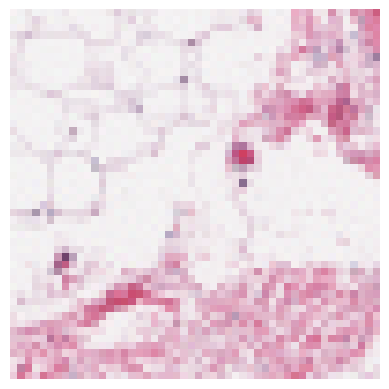

hog_image.shape:  (50, 50)

hog_image: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


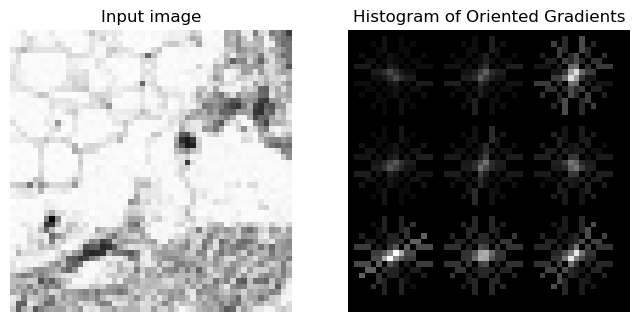

In [11]:
# use HOG to extract features
from skimage.feature import hog
from skimage import data, exposure, color, transform
import matplotlib.image as mpimg
import random
import numpy as np

# extract features and labels for all images
hog_features = []
labels = []
for region in observations.index.values:
    img = mpimg.imread(observations.loc[region, 'path'])
    img = transform.resize(img, (50, 50))
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = color.rgb2gray(img)
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_features.append(fd)
    labels.append(observations.loc[region, 'class'])


# randomly select a patient
rand_pat = observations.index.values[random.randint(0, len(observations) - 1)]
print('randomly selected patch: ', rand_pat)
print('class: ', observations.loc[rand_pat, 'class'])
print('path: ', observations.loc[rand_pat, 'path'])

# show the image
img = mpimg.imread(observations.loc[rand_pat, 'path'])
plt.axis('off')
plt.grid(False)
plt.imshow(img, cmap='gray')
plt.show()

# convert the image to grayscale if it is a color image
if len(img.shape) == 3 and img.shape[2] == 3:
    img = color.rgb2gray(img)

# extract features
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
print('hog_image.shape: ', hog_image.shape)
print('\nhog_image: \n', hog_image, sep='')

# show the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [7]:
# train test split using hog_features and labels
from sklearn.model_selection import train_test_split

hog_features = np.vstack(hog_features)

X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)


# train a SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('SVM accuracy: ', accuracy_score(y_test, y_pred))

# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('RF accuracy: ', accuracy_score(y_test, y_pred))

# train a lightgbm classifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('LGBM accuracy: ', accuracy_score(y_test, y_pred))

# train a xgboost classifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('XGB accuracy: ', accuracy_score(y_test, y_pred))


SVM accuracy:  0.7105
RF accuracy:  0.7105
LGBM accuracy:  0.7125
XGB accuracy:  0.6965


In [8]:
from sklearn.model_selection import GridSearchCV

# For SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 
grid_svm = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid_svm.fit(X_train,y_train)
y_pred_svm = grid_svm.predict(X_test)


# For Random Forest
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)


# For LightGBM
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [-1, 10, 20]}
grid_lgbm = GridSearchCV(lgb.LGBMClassifier(), param_grid, refit=True, verbose=2)
grid_lgbm.fit(X_train, y_train)
y_pred_lgbm = grid_lgbm.predict(X_test)


# For XGBoost
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 6, 10]}
grid_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid, refit=True, verbose=2)
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.6s
[CV] END ......................C=0.1, gamma=0.01

In [9]:
print('Best parameters for SVM: ', grid_svm.best_params_)
print('SVM accuracy: ', accuracy_score(y_test, y_pred_svm))

print('Best parameters for Random Forest: ', grid_rf.best_params_)
print('RF accuracy: ', accuracy_score(y_test, y_pred_rf))

print('Best parameters for LightGBM: ', grid_lgbm.best_params_)
print('LGBM accuracy: ', accuracy_score(y_test, y_pred_lgbm))

print('Best parameters for XGBoost: ', grid_xgb.best_params_)
print('XGB accuracy: ', accuracy_score(y_test, y_pred_xgb))

Best parameters for SVM:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVM accuracy:  0.7105
Best parameters for Random Forest:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
RF accuracy:  0.7175
Best parameters for LightGBM:  {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200}
LGBM accuracy:  0.717
Best parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGB accuracy:  0.7245
